# 🏀 NBA Dream Team Predictor

Ce notebook présente clairement toutes les étapes du projet visant à prédire la meilleure équipe NBA de 5 joueurs ('Dream Team') par saison.

# Importation des données

In [7]:
import pandas as pd

seasons=pd.read_csv('../Data/v1/df_all_seasons_cleaned.csv')
games=pd.read_csv('../Data/v1/df_game_cleaned.csv')
players=pd.read_csv('../Data/v1/df_player_cleaned.csv')
players2=pd.read_csv('../Data/v1/df_common_players_cleaned.csv')
score=pd.read_csv('../Data/v1/df_line_score_cleaned.csv')
team_df=pd.read_csv('../Data/v1/df_team_cleaned.csv')
all=pd.read_csv('../Data/v1/df_all.csv')

In [8]:
score.columns

Index(['game_date_est', 'game_id', 'team_id_home', 'team_abbreviation_home',
       'team_city_name_home', 'team_nickname_home', 'team_wins_losses_home',
       'pts_qtr1_home', 'pts_qtr2_home', 'pts_qtr3_home', 'pts_qtr4_home',
       'pts_ot1_home', 'pts_ot2_home', 'pts_ot3_home', 'pts_ot4_home',
       'pts_ot5_home', 'pts_ot6_home', 'pts_ot7_home', 'pts_ot8_home',
       'pts_ot9_home', 'pts_ot10_home', 'pts_home', 'team_id_away',
       'team_abbreviation_away', 'team_city_name_away', 'team_nickname_away',
       'team_wins_losses_away', 'pts_qtr1_away', 'pts_qtr2_away',
       'pts_qtr3_away', 'pts_qtr4_away', 'pts_ot1_away', 'pts_ot2_away',
       'pts_ot3_away', 'pts_ot4_away', 'pts_ot5_away', 'pts_ot6_away',
       'pts_ot7_away', 'pts_ot8_away', 'pts_ot9_away', 'pts_ot10_away',
       'pts_away'],
      dtype='object')

In [21]:
seasons.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


# Création d'un dataset merge

In [25]:
import pandas as pd

# 2. Préparer games → win_rate par équipe/saison
games['season'] = games['season_id'].apply(lambda x: f"{str(x)[-4:]}-{str(int(str(x)[-4:])+1)[-2:]}")
# extraire home/away → stack pour avoir col. [season, team_abbreviation, wl]
home = games[['season','team_abbreviation_home','wl_home']].rename(
    columns={'team_abbreviation_home':'team','wl_home':'wl'})
away = games[['season','team_abbreviation_away','wl_away']].rename(
    columns={'team_abbreviation_away':'team','wl_away':'wl'})
df_results = pd.concat([home,away], ignore_index=True)
team_wr = (df_results
           .groupby(['season','team'])['wl']
           .value_counts(normalize=True)
           .unstack(fill_value=0)
           .rename(columns={'W':'win_rate'})
           .reset_index()[['season','team','win_rate']]
          )

# 3. Préparer score → moyenne de pts par équipe/saison
# idem : transformer home/away en long, puis merge avec games[['game_id','season']]
score_home = score[['game_id','team_abbreviation_home','pts_home']].rename(
    columns={'team_abbreviation_home':'team','pts_home':'pts'})
score_away = score[['game_id','team_abbreviation_away','pts_away']].rename(
    columns={'team_abbreviation_away':'team','pts_away':'pts'})
score_long = pd.concat([score_home,score_away], ignore_index=True)
score2 = pd.merge(score_long,
                  games[['game_id','season']],
                  on='game_id', how='left')
team_avg_pts = (score2
                .groupby(['season','team'])['pts']
                .mean()
                .reset_index()
                .rename(columns={'pts':'avg_pts'})
               )

# 4. Jointure principale : seasons + players2 (pour person_id+position)
df = pd.merge(
    seasons,
    players2[['display_first_last','team_abbreviation','person_id','position']],
    left_on=['player_name','team_abbreviation'],
    right_on=['display_first_last','team_abbreviation'],
    how='left'
)

# 5. Ajouter l’identité détaillée du joueur (players)
df = pd.merge(
    df,
    players[['id','first_name','last_name','is_active']],
    right_on='id',
    how='left'
)

# 6. Ajouter les infos équipe (team)
df = pd.merge(
    df,
    team[['abbreviation','full_name','nickname','city']],
    left_on='team_abbreviation',
    right_on='abbreviation',
    how='left'
).rename(columns={
    'full_name':'team_full_name',
    'nickname':'team_nickname',
    'city':'team_city'
})

# 7. Ajouter win_rate et avg_pts
df = pd.merge(df, team_wr,      left_on=['season','team_abbreviation'], right_on=['season','team'], how='left')
df = pd.merge(df, team_avg_pts, left_on=['season','team_abbreviation'], right_on=['season','team'], how='left')

# Le DataFrame df contient désormais, ligne par ligne :
#   • les stats individuelles du joueur (seasons)
#   • son person_id & position (players2)
#   • son identité (players)
#   • les métadonnées de l’équipe (team)
#   • son taux de victoire de l’équipe (team_wr)
#   • la moyenne de points de l’équipe (team_avg_pts)


In [28]:
df.describe()

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,person_id,id,win_rate,avg_pts
count,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,3.760000e+03,3.760000e+03,12816.000000,12816.000000
mean,27.049001,200.551316,100.262730,51.264747,8.229760,3.565863,1.828675,-2.118844,0.054087,0.140775,0.184570,0.513837,0.131839,4.494835e+05,4.494835e+05,0.490020,100.838661
std,4.339038,9.109069,12.427861,25.001429,6.011792,2.475488,1.800827,10.604280,0.042485,0.061690,0.052388,0.098829,0.094016,6.718954e+05,6.718954e+05,0.145423,7.555756
min,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,-98.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,2.000000e+00,0.000000,81.804878
25%,24.000000,193.040000,90.718400,31.000000,3.600000,1.800000,0.600000,-6.300000,0.021000,0.096000,0.149000,0.482000,0.066000,1.749000e+03,1.749000e+03,0.388889,95.266667
50%,26.000000,200.660000,99.790240,57.000000,6.700000,3.000000,1.200000,-1.300000,0.041000,0.131000,0.181000,0.525000,0.103000,1.011525e+05,1.011525e+05,0.500000,99.407895
75%,30.000000,208.280000,108.862080,73.000000,11.500000,4.700000,2.400000,3.200000,0.083000,0.179000,0.217000,0.563000,0.179000,2.039940e+05,2.039940e+05,0.595745,106.104167
max,44.000000,231.140000,163.293120,85.000000,36.100000,16.300000,11.700000,95.000000,0.600000,1.000000,0.595000,1.500000,1.000000,1.631323e+06,1.631323e+06,0.857143,119.252874


## Cleaning du dataset merge (-> obtention de df_v1)

In [18]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12816 entries, 0 to 12815
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         12816 non-null  object 
 1   team_abbreviation   12816 non-null  object 
 2   age                 12816 non-null  float64
 3   player_height       12816 non-null  float64
 4   player_weight       12816 non-null  float64
 5   college             12816 non-null  object 
 6   country             12816 non-null  object 
 7   draft_year          12816 non-null  object 
 8   draft_round         12816 non-null  object 
 9   draft_number        12816 non-null  object 
 10  gp                  12816 non-null  int64  
 11  pts                 12816 non-null  float64
 12  reb                 12816 non-null  float64
 13  ast                 12816 non-null  float64
 14  net_rating          12816 non-null  float64
 15  oreb_pct            12816 non-null  float64
 16  dreb

In [23]:
all = all.drop(columns=['team_nickname'])

In [30]:
# Remplir les valeurs manquantes dans la colonne "position" en utilisant les positions existantes pour le même player_name
all['position'] = all.groupby('player_name')['position'].transform(lambda x: x.ffill().bfill())

/var/folders/t6/j8g_7ls97b9gdfqfkc7p75q80000gn/T/ipykernel_45436/3628446723.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all['position'] = all.groupby('player_name')['position'].transform(lambda x: x.ffill().bfill())


In [33]:
all['person_id'] = all.groupby('player_name')['person_id'].transform(lambda x: x.ffill().bfill())

In [34]:
all.isna().sum()

player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college                 0
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
person_id            4880
position             4880
is_active            9056
team_full_name        771
team_city             771
team_x                  0
win_rate                0
team_y                  0
avg_pts                 0
dtype: int64

In [35]:
all.to_csv('../Data/df_v1.csv', index=False)

# Modèle

## Test sur la saison 2022-23


Le modèle utilise plusieurs métriques calculées pour évaluer l'impact des joueurs:

1. **Stats normalisées par match**
    - `pts_per_game` = `pts` / `gp` (points par match)
    - `reb_per_game` = `reb` / `gp` (rebonds par match)
    - `ast_per_game` = `ast` / `gp` (passes par match)
2. **Ratios avancés**
    - `ast_usg_ratio` = `ast_pct` / `usg_pct` (efficacité de création)
    - `reb_pct_sum` = `oreb_pct` + `dreb_pct` (impact global au rebond)
    - `net_rating` (différentiel offensif/défensif par 100 possessions)
3. **Postes de jeu**
    - Extraction du poste primaire: **G** (Guard), **F** (Forward), **C** (Center)

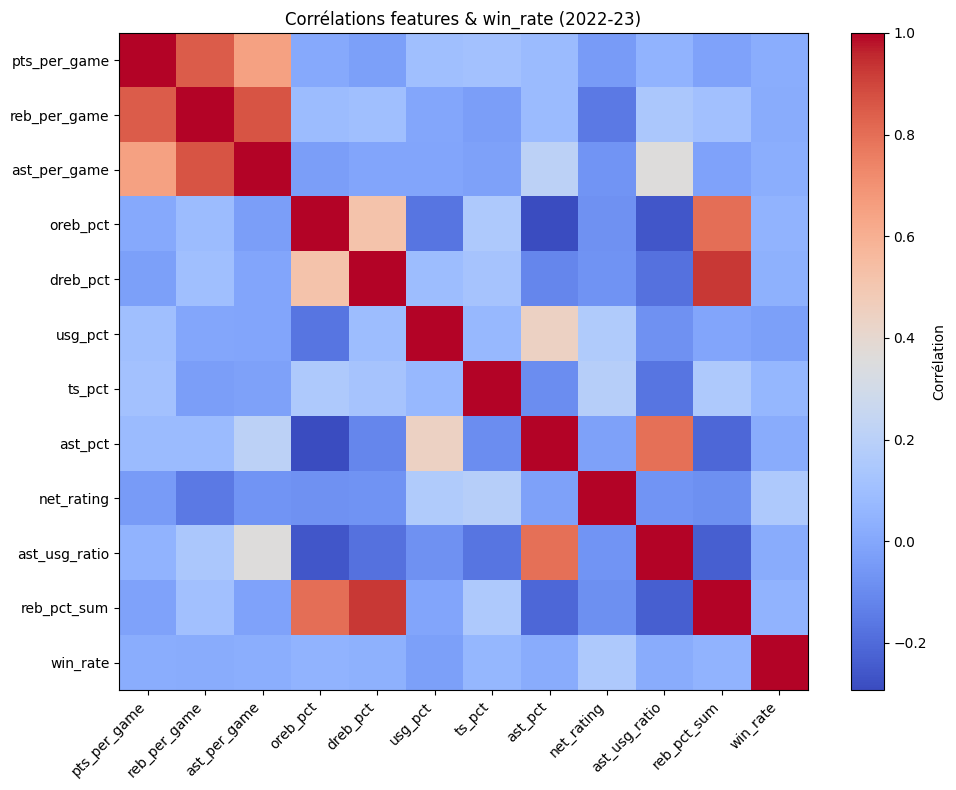


Top features corrélées avec win_rate :
net_rating       0.155524
ts_pct           0.063068
oreb_pct         0.048207
reb_pct_sum      0.046682
dreb_pct         0.036559
ast_per_game     0.029834
usg_pct          0.025547
pts_per_game     0.020716
ast_pct          0.020341
ast_usg_ratio    0.020289
reb_per_game     0.017806
Name: win_rate, dtype: float64


/var/folders/t6/j8g_7ls97b9gdfqfkc7p75q80000gn/T/ipykernel_45436/3807286183.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.nlargest(5, "pts"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth


Dream Team 2022-23 (top critères) :
               player      position  net_rating  ts_pct  oreb_pct  reb_pct_sum  dreb_pct  predicted_win_rate
         Jrue Holiday         Guard         9.2   0.586     0.035        0.142     0.107            0.793665
         Jayson Tatum Forward-Guard         8.5   0.607     0.029        0.229     0.200            0.793665
         Aaron Gordon       Forward        12.1   0.617     0.086        0.222     0.136            0.793665
Giannis Antetokounmpo       Forward         7.2   0.605     0.065        0.333     0.268            0.793665
      Marko Simonovic        Center        27.3   0.381     0.043        0.102     0.059            0.793665


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/l

In [47]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations

def get_primary_pos(pos):
    if pd.isna(pos):
        return np.nan
    if "Guard" in pos and "Center" not in pos:
        return "G"
    if "Center" in pos:
        return "C"
    if "Forward" in pos:
        return "F"
    return np.nan

def main():
    # 1. Charger le dataset fusionné
    df = pd.read_csv("../Data/df_v1.csv")
    
    # 2. Définir la saison cible et isoler
    season = "2022-23"
    df_season = df[df["season"] == season].copy()
    
    # 3. Déduire primary_pos depuis 'position'
    df_season["primary_pos"] = df_season["position"].apply(get_primary_pos)
    
    # 4. Feature engineering (sur tout df et df_season)
    for d in (df, df_season):
        d["pts_per_game"]   = d["pts"] / d["gp"]
        d["reb_per_game"]   = d["reb"] / d["gp"]
        d["ast_per_game"]   = d["ast"] / d["gp"]
        d["ast_usg_ratio"]  = d["ast_pct"] / (d["usg_pct"] + 1e-6)
        d["reb_pct_sum"]    = d["oreb_pct"] + d["dreb_pct"]
    
    # 5. Analyse préliminaire : heatmap et corrélations vs win_rate
    features_all = [
        "pts_per_game", "reb_per_game", "ast_per_game",
        "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct",
        "net_rating", "ast_usg_ratio", "reb_pct_sum"
    ]
    corr = df_season[features_all + ["win_rate"]].corr()
    
    plt.figure(figsize=(10,8))
    plt.imshow(corr, aspect="auto", cmap="coolwarm")
    plt.xticks(np.arange(len(corr)), corr.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(corr)), corr.index)
    plt.colorbar(label="Corrélation")
    plt.title(f"Corrélations features & win_rate ({season})")
    plt.tight_layout()
    plt.show()
    
    # Extraire corrélations absolues avec win_rate
    corr_win = corr["win_rate"].abs().drop("win_rate").sort_values(ascending=False)
    print("\nTop features corrélées avec win_rate :")
    print(corr_win)
    
    # 6. Choisir les top 5 features corrélées avec win_rate comme critères
    top_features = corr_win.index.tolist()[:5]
    
    # 7. Entraînement du modèle sur les autres saisons
    train = df[df["season"] != season]
    top5 = train.groupby(["season","team_abbreviation"], group_keys=False)\
                .apply(lambda grp: grp.nlargest(5, "pts"))
    agg = top5.groupby(["season","team_abbreviation"])[top_features]\
               .mean().reset_index()
    team_wr = df[["season","team_abbreviation","win_rate"]].drop_duplicates()
    train_df = pd.merge(agg, team_wr, on=["season","team_abbreviation"], how="left")
    
    X_train = train_df[top_features]
    y_train = train_df["win_rate"]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # 8. Recherche de la Dream Team 2022-23 (2G, 2F, 1C)
    candidates = {
        "G": df_season[df_season["primary_pos"] == "G"].nlargest(10, "net_rating"),
        "F": df_season[df_season["primary_pos"] == "F"].nlargest(10, "net_rating"),
        "C": df_season[df_season["primary_pos"] == "C"].nlargest(5,  "net_rating"),
    }
    
    best_score = -1
    best_lineup = None
    
    for g_combo in combinations(candidates["G"].itertuples(), 2):
        for f_combo in combinations(candidates["F"].itertuples(), 2):
            for c in candidates["C"].itertuples():
                lineup = list(g_combo) + list(f_combo) + [c]
                feats = np.mean(
                    [[getattr(p, feat) for feat in top_features] for p in lineup],
                    axis=0
                ).reshape(1, -1)
                pred = model.predict(feats)[0]
                if pred > best_score:
                    best_score, best_lineup = pred, lineup
    
    # 9. Assemblage et affichage de la Dream Team retenue
    dream = pd.DataFrame([{
        "player": p.player_name,
        "position": p.position,
        **{ feat: getattr(p, feat) for feat in top_features }
    } for p in best_lineup])
    dream["predicted_win_rate"] = best_score
    
    print("\nDream Team 2022-23 (top critères) :")
    print(dream.to_string(index=False))

if __name__ == "__main__":
    main()


## Application sur les années 2000-2025

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations

def get_primary_pos(pos):
    if pd.isna(pos):
        return np.nan
    if "Guard" in pos and "Center" not in pos:
        return "G"
    if "Center" in pos:
        return "C"
    if "Forward" in pos:
        return "F"
    return np.nan

def compute_dream_team(df, season, features, model, top_net=10, center_net=5):
    df_season = df[df["season"] == season].copy()
    df_season["primary_pos"] = df_season["position"].apply(get_primary_pos)
    candidates = {
        "G": df_season[df_season["primary_pos"] == "G"].nlargest(top_net,   "net_rating"),
        "F": df_season[df_season["primary_pos"] == "F"].nlargest(top_net,   "net_rating"),
        "C": df_season[df_season["primary_pos"] == "C"].nlargest(center_net, "net_rating"),
    }
    best_score = -1
    best_lineup = None

    for g in combinations(candidates["G"].itertuples(), 2):
        for f in combinations(candidates["F"].itertuples(), 2):
            for c in candidates["C"].itertuples():
                lineup = list(g) + list(f) + [c]
                feats = np.array([[getattr(p, feat) for feat in features] for p in lineup])
                avg_feats = feats.mean(axis=0).reshape(1, -1)
                score = model.predict(avg_feats)[0]
                if score > best_score:
                    best_score, best_lineup = score, lineup

    dream = pd.DataFrame([{
        "season": season,
        "player": p.player_name,
        "position": p.position,
        **{ feat: getattr(p, feat) for feat in features }
    } for p in best_lineup])
    dream["predicted_win_rate"] = best_score
    return dream

def main():
    # 1. Charger le dataset fusionné
    df = pd.read_csv("../Data/df_v1.csv")

    # 2. Feature engineering
    df["pts_per_game"]  = df["pts"] / df["gp"]
    df["reb_per_game"]  = df["reb"] / df["gp"]
    df["ast_per_game"]  = df["ast"] / df["gp"]
    df["ast_usg_ratio"] = df["ast_pct"] / (df["usg_pct"] + 1e-6)
    df["reb_pct_sum"]   = df["oreb_pct"] + df["dreb_pct"]

    # 3. Sélection des features pour le modèle
    features_all = [
        "pts_per_game", "reb_per_game", "ast_per_game",
        "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct",
        "net_rating", "ast_usg_ratio", "reb_pct_sum"
    ]

    # 4. Boucle sur les saisons 2000-01 à 2024-25
    dreams = []
    for year in range(2000, 2025):
        season = f"{year}-{str(year+1)[-2:]}"
        if season not in df["season"].unique():
            continue

        # Préparer les données d'entraînement (toutes les autres saisons)
        train = df[df["season"] != season]
        top5 = train.groupby(["season", "team_abbreviation"], group_keys=False) \
                    .apply(lambda grp: grp.nlargest(5, "pts"))
        agg = top5.groupby(["season", "team_abbreviation"])[features_all] \
                   .mean().reset_index()
        team_wr = df[["season", "team_abbreviation", "win_rate"]].drop_duplicates()
        train_df = pd.merge(agg, team_wr, on=["season", "team_abbreviation"], how="left")

        # Entraîner le modèle
        X_train = train_df[features_all]
        y_train = train_df["win_rate"]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Calculer la Dream Team pour cette saison
        dream = compute_dream_team(df, season, features_all, model)
        dreams.append(dream)

    # 5. Concaténer et sauvegarder les résultats
    all_dreams = pd.concat(dreams, ignore_index=True)
    all_dreams.to_csv("dream_teams_2000_2024.csv", index=False)
    print("Dream teams saved to dream_teams_2000_2024.csv")
    print(all_dreams)

if __name__ == "__main__":
    main()




# Amélioration du modèle, utilisation de RandForestRegressor et GradientBoost


## Modélisation

Pour chaque saison, nous suivons un processus rigoureux:

1. **Entraînement**
    - Données: toutes les saisons sauf celle évaluée
    - Features: moyennes des statistiques des 5 meilleurs scoreurs par équipe
    - Target: `win_rate` de l'équipe
2. **Comparaison de modèles**
    - **Random Forest Regressor**: modèle ensemble robuste aux outliers
    - **Gradient Boosting Regressor**: modèle séquentiel généralement plus précis
3. **Métriques d'évaluation**
    - **RMSE** (Root Mean Square Error): mesure la précision des prédictions
    - **R²**: pourcentage de variance expliquée par le modèle
4. **Fine-tuning des hyperparamètres** (tous les 5 ans)
    - Optimisation par GridSearchCV avec validation croisée
    - Paramètres optimisés: nombre d'arbres, profondeur, critères de division, etc.
5. **Recherche de la Dream Team**
    - Définition d'un pool de candidats: Top joueurs par position selon `net_rating`
    - Évaluation de toutes les combinaisons valides (2G-2F-1C)
    - Sélection de la composition avec le meilleur taux de victoire prédit


In [ ]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
import time

def get_primary_pos(pos):
    if pd.isna(pos):
        return np.nan
    if "Guard" in pos and "Center" not in pos:
        return "G"
    if "Center" in pos:
        return "C"
    if "Forward" in pos:
        return "F"
    return np.nan

def compute_dream_team(df, season, features, model, top_net=10, center_net=5):
    df_season = df[df["season"] == season].copy()
    df_season["primary_pos"] = df_season["position"].apply(get_primary_pos)
    candidates = {
        "G": df_season[df_season["primary_pos"] == "G"].nlargest(top_net,   "net_rating"),
        "F": df_season[df_season["primary_pos"] == "F"].nlargest(top_net,   "net_rating"),
        "C": df_season[df_season["primary_pos"] == "C"].nlargest(center_net, "net_rating"),
    }
    best_score = -1
    best_lineup = None

    for g in combinations(candidates["G"].itertuples(), 2):
        for f in combinations(candidates["F"].itertuples(), 2):
            for c in candidates["C"].itertuples():
                lineup = list(g) + list(f) + [c]
                feats = np.array([[getattr(p, feat) for feat in features] for p in lineup])
                avg_feats = feats.mean(axis=0).reshape(1, -1)
                score = model.predict(avg_feats)[0]
                if score > best_score:
                    best_score, best_lineup = score, lineup

    dream = pd.DataFrame([{
        "season": season,
        "player": p.player_name,
        "position": p.position,
        **{ feat: getattr(p, feat) for feat in features }
    } for p in best_lineup])
    dream["predicted_win_rate"] = best_score
    return dream

def evaluate_model(model, X, y):
    """Évalue le modèle avec RMSE et R² sur les données fournies"""
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return {'rmse': rmse, 'r2': r2}

def fine_tune_model(X, y, model_type='rf'):
    """Effectue une recherche par grille pour trouver les meilleurs hyperparamètres"""
    if model_type == 'rf':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestRegressor(random_state=42)
    elif model_type == 'gb':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
        model = GradientBoostingRegressor(random_state=42)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=kfold,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    print(f"Best parameters for {model_type}: {grid_search.best_params_}")
    print(f"Best score: {-grid_search.best_score_:.4f} RMSE")
    
    return grid_search.best_estimator_

def main():
    # 1. Charger le dataset fusionné
    df = pd.read_csv("../Data/df_v1.csv")

    # 2. Feature engineering
    df["pts_per_game"]  = df["pts"] / df["gp"]
    df["reb_per_game"]  = df["reb"] / df["gp"]
    df["ast_per_game"]  = df["ast"] / df["gp"]
    df["ast_usg_ratio"] = df["ast_pct"] / (df["usg_pct"] + 1e-6)
    df["reb_pct_sum"]   = df["oreb_pct"] + df["dreb_pct"]

    # 3. Sélection des features pour le modèle
    features_all = [
        "pts_per_game", "reb_per_game", "ast_per_game",
        "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct",
        "net_rating", "ast_usg_ratio", "reb_pct_sum"
    ]

    # 4. Boucle sur les saisons 2000-01 à 2024-25
    dreams_rf = []
    dreams_gb = []
    metrics = []
    
    for year in range(2000, 2025):
        season = f"{year}-{str(year+1)[-2:]}"
        if season not in df["season"].unique():
            continue

        print(f"\nProcessing season: {season}")
        
        # Préparer les données d'entraînement (toutes les autres saisons)
        train = df[df["season"] != season]
        top5 = train.groupby(["season", "team_abbreviation"], group_keys=False) \
                    .apply(lambda grp: grp.nlargest(5, "pts"))
        agg = top5.groupby(["season", "team_abbreviation"])[features_all] \
                   .mean().reset_index()
        team_wr = df[["season", "team_abbreviation", "win_rate"]].drop_duplicates()
        train_df = pd.merge(agg, team_wr, on=["season", "team_abbreviation"], how="left")

        # Préparer données de test (saison actuelle pour validation)
        test = df[df["season"] == season]
        test_top5 = test.groupby(["season", "team_abbreviation"], group_keys=False) \
                      .apply(lambda grp: grp.nlargest(5, "pts"))
        test_agg = test_top5.groupby(["season", "team_abbreviation"])[features_all] \
                           .mean().reset_index()
        test_wr = test[["season", "team_abbreviation", "win_rate"]].drop_duplicates()
        test_df = pd.merge(test_agg, test_wr, on=["season", "team_abbreviation"], how="left")

        # Entraîner les modèles
        X_train = train_df[features_all]
        y_train = train_df["win_rate"]
        X_test = test_df[features_all]
        y_test = test_df["win_rate"]
        
        # 5. Fine-tuning des modèles (pour économiser du temps, on ne le fait que tous les 5 ans)
        if year % 5 == 0:
            print("Fine-tuning Random Forest model...")
            start_time = time.time()
            rf_model = fine_tune_model(X_train, y_train, 'rf')
            rf_time = time.time() - start_time
            
            print("Fine-tuning Gradient Boosting model...")
            start_time = time.time()
            gb_model = fine_tune_model(X_train, y_train, 'gb')
            gb_time = time.time() - start_time
        else:
            # Utiliser des modèles par défaut pour les autres années
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)
            rf_time = 0
            
            gb_model = GradientBoostingRegressor(random_state=42)
            gb_model.fit(X_train, y_train)
            gb_time = 0

        # 6. Évaluation des modèles
        rf_metrics = evaluate_model(rf_model, X_test, y_test)
        gb_metrics = evaluate_model(gb_model, X_test, y_test)
        
        print(f"Random Forest - RMSE: {rf_metrics['rmse']:.4f}, R²: {rf_metrics['r2']:.4f}")
        print(f"Gradient Boosting - RMSE: {gb_metrics['rmse']:.4f}, R²: {gb_metrics['r2']:.4f}")
        
        metrics.append({
            'season': season,
            'rf_rmse': rf_metrics['rmse'],
            'rf_r2': rf_metrics['r2'],
            'rf_time': rf_time,
            'gb_rmse': gb_metrics['rmse'],
            'gb_r2': gb_metrics['r2'],
            'gb_time': gb_time
        })

        # 7. Calculer la Dream Team pour cette saison avec les deux modèles
        dream_rf = compute_dream_team(df, season, features_all, rf_model)
        dream_rf['model'] = 'RandomForest'
        dreams_rf.append(dream_rf)
        
        dream_gb = compute_dream_team(df, season, features_all, gb_model)
        dream_gb['model'] = 'GradientBoosting'
        dreams_gb.append(dream_gb)

    # 8. Concaténer et sauvegarder les résultats
    all_dreams_rf = pd.concat(dreams_rf, ignore_index=True)
    all_dreams_rf.to_csv("dream_teams_rf_2000_2024.csv", index=False)
    
    all_dreams_gb = pd.concat(dreams_gb, ignore_index=True)
    all_dreams_gb.to_csv("dream_teams_gb_2000_2024.csv", index=False)
    
    # Sauvegarder les métriques
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv("model_metrics_2000_2024.csv", index=False)
    
    # Afficher un résumé des performances des modèles
    print("\nRésumé des performances des modèles:")
    print(f"Random Forest - RMSE moyen: {metrics_df['rf_rmse'].mean():.4f}, R² moyen: {metrics_df['rf_r2'].mean():.4f}")
    print(f"Gradient Boosting - RMSE moyen: {metrics_df['gb_rmse'].mean():.4f}, R² moyen: {metrics_df['gb_r2'].mean():.4f}")
    
    # Visualiser les performances des modèles
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(metrics_df['season'], metrics_df['rf_rmse'], 'b-o', label='RandomForest')
    plt.plot(metrics_df['season'], metrics_df['gb_rmse'], 'r-o', label='GradientBoosting')
    plt.title('RMSE par saison')
    plt.xlabel('Saison')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics_df['season'], metrics_df['rf_r2'], 'b-o', label='RandomForest')
    plt.plot(metrics_df['season'], metrics_df['gb_r2'], 'r-o', label='GradientBoosting')
    plt.title('R² par saison')
    plt.xlabel('Saison')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_performance.png')
    plt.show()

    print("Analyses sauvegardées dans les fichiers CSV et visualisations générées.")

if __name__ == "__main__":
    main()